# Importing libraries and reading in file

In [2]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark import SparkContext

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Detecting-Malicious-URL App")\
        .getOrCreate()

#Reading in the URL file and storing into dataframe
data_df = spark.read.csv(path='dataset.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

data_df.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,1000000


# Under Sample Unbalanced Datasets

In [3]:

malicious = data_df.filter("label = 1")
bening = data_df.filter("label = 0")

#malicious.count()
#bening.count()

sampleRatio = malicious.count() / data_df.count()
#print("sampleRatio: %g" %sampleRatio)
sample_bening = bening.sample(False, sampleRatio)

sampled = malicious.unionAll(sample_bening)

sampled.groupby('label').count().toPandas()



,label,count
0,1,56937
1,0,53650


# Data Ingestion and Vectorization

In [4]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

#Note: this is not used in production as it gives less results during model training
idf = IDF(inputCol=countVectors.getOutputCol(), outputCol="features") 

#create the pipline 
pipeline = Pipeline(stages=[regexTokenizer, countVectors, idf ])


# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(data_df)

#Transform the pipeline to dataset
dataset = pipelineFit.transform(data_df)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.show(5)


Training Dataset Count: 844745
Test Dataset Count: 212192
Total Dataset Count: 1056937
+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(10000,[0,3,13,16...|(10000,[0,3,13,16...|
|https://semana-da...|    1|[https, semana, d...|(10000,[0,16,24,4...|(10000,[0,16,24,4...|
|https://scrid-app...|    1|[https, scrid, ap...|(10000,[0,24,904]...|(10000,[0,24,904]...|
|http://my-softban...|    1|[http, my, softba...|(10000,[0,3,70,90...|(10000,[0,3,70,90...|
|http://www.my-sof...|    1|[http, www, my, s...|(10000,[0,3,18,70...|(10000,[0,3,18,70...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [5]:
trainingData.groupby('label').count().toPandas()

,label,count
0,1,45430
1,0,799315


# Logistic Regression


Root Mean Squared Error (RMSE) on test data = 0.143229

AreaUnderROC on Test Data = 99.4669
True Positives: 7154
True Negative: 200685
False Positive: 0
False Negative: 4353
Total: 212192
Recal: 62.1709
Precision: 100
Accuracy: 97.9486


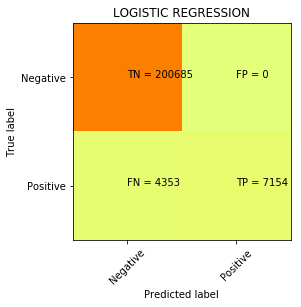

In [6]:
#==============[ LOGISTIC REGRESSION ]=========================
accuracy = 0.0
average_accuracy = 0.0


# Build logistic regresssion model
for i in range(1,2):
    
    lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
    # Train model using logisitic regression
    lrModel = lr.fit(trainingData)

    #Doing the prediction using test data
    #Label is not used in test data
    predictions = lrModel.transform(testData)

  #  predictions.select("url", "label", "prediction").show(n=5, truncate = 100)
# Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("\nRoot Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions)
    
    average_accuracy = accuracy + average_accuracy

    print("\nAreaUnderROC on Test Data = %g" % (accuracy*100))
    
   # print("test accuracy with pipeline " + accuracyScore(lrModel.transform(testData), "label", "prediction"))
    #print("test recall for 1.0 is " + recall(lrModel.transform(testData), "label", "prediction", 1))

#average_accuracy = average_accuracy/i    
#print("\nAverage Accuracy on test for %i run is: %g" % (i, (average_accuracy *100)))
#evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
#print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
#print("Test: Area Under PR - precision-recall curve: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

#evaluator_p = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
#precision = evaluator_p.evaluate(predictions,{evaluator.metricName: "precision"})
#print("Precision %g" % (precision *100))

#evaluator_r = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
#recall_ = evaluator_p.evaluate(predictions,{evaluator.metricName: "recall"})
#print("Recall %g" % (recall_*100))

#===========================
df = predictions.select('prediction', 'label')
#predictionAndLabels=df.rdd

#metrics = MulticlassMetrics(predictionAndLabels) 

#accuracy=(cm[0][0]+cm[1][1])/cm.sum()
#print(accuracy)

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)

print("Recal: %g" %(r*100))
print("Precision: %g" %(p*100))
print("Accuracy: %g" %(a*100))

#df.show(30)

#===========================ploting

#plt.clf()
lr_predictions = lrModel.transform(testData)

y_actu = lr_predictions.select("label").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#===============================================================

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

#Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

predictions.filter(predictions['prediction'] == 0) \
    .select("url", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 80)
    
#Precision measures the percentage of URLs flagged as malicious that were correctly classified
#Recall measures the percentage of actual Malicious URLs that were correctly classified

# Cross Validation for Logistic Regression

Test: Area Under ROC: 0.9946980085429543
Precision 98.9368
Recall 98.9368
True Positives: 9357
True Negative: 200684
False Positive: 1
False Negative: 2150
Total: 212192
Recal: 81.3157
Precision: 99.9893
Accuracy: 98.9863


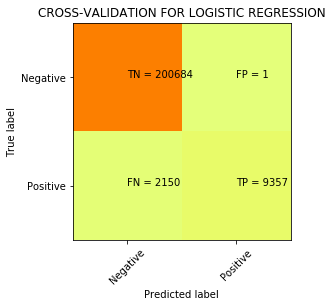

In [7]:
#==============[ Cross Validation for Logistic Regression ]=====================
# Creating ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 10-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

evaluator_p = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
precision = evaluator_p.evaluate(predictions,{evaluator.metricName: "precision"})
print("Precision %g" % (precision *100))

evaluator_r = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
recall = evaluator_r.evaluate(predictions,{evaluator.metricName: "recall"})
print("Recall %g" % (recall*100))

#================================================================
df = predictions.select('prediction', 'label')

predictionAndLabels=df.rdd
metrics = MulticlassMetrics(predictionAndLabels) 



tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)

print("Recal: %g" %(r*100))
print("Precision: %g" %(p*100))
print("Accuracy: %g" %(a*100))

#=============================================================

cv_predictions = cvModel.transform(testData)

y_actu = cv_predictions.select("label").toPandas()
y_pred = cv_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('CROSS-VALIDATION FOR LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Naive Bayes

Test: Area Under ROC: 0.9840193706157522
True Positives: 11250
True Negative: 198753
False Positive: 1932
False Negative: 257
Total: 212192
Recal: 97.7666
Precision: 85.3437
Accuracy: 98.9684


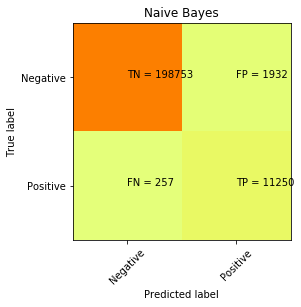

In [8]:

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial",)

# train the model
model = nb.fit(trainingData)

# select example rows to display.
predictions = model.transform(testData)


# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#===========================
df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)

print("Recal: %g" %(r*100))
print("Precision: %g" %(p*100))
print("Accuracy: %g" %(a*100))

#===========================ploting

#plt.clf()
nb_predictions = model.transform(testData)

y_actu = nb_predictions.select("label").toPandas()
y_pred = nb_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Linear Support Vector Machine

Root Mean Squared Error (RMSE) on test data = 0.0547905
True Positives: 10895
True Negative: 200660
False Positive: 25
False Negative: 612
Total: 212192
Recal: 94.6815
Precision: 99.7711
Accuracy: 99.6998


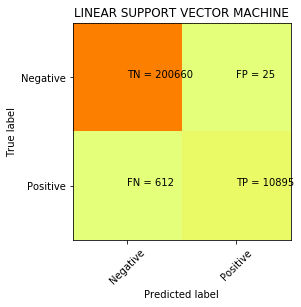

In [9]:
#==============[ Linear Support Vector Machine ]=====================

for i in range(1, 2):
    

    lsvc = LinearSVC(maxIter=10, regParam=0.3)

    # Fit the model
    lsvcModel = lsvc.fit(trainingData)

    predictions = lsvcModel.transform(testData)

    #predictions.select("url", "label", "prediction").show(n=5, truncate = 100)

    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions)

    
    #================================================================
    df = predictions.select('prediction', 'label')
    predictionAndLabels=df.rdd

    metrics = MulticlassMetrics(predictionAndLabels) 

    

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)

    print("Recal: %g" %(r*100))
    print("Precision: %g" %(p*100))
    print("Accuracy: %g" %(a*100))

#=============================================================
    
    #==================[ Confusing Matrix Calculation and Plotting ]
    lsvm_predictions = lsvcModel.transform(testData)


    y_actu = lsvm_predictions.select("label").toPandas()
    y_pred = lsvm_predictions.select("prediction").toPandas()

    cm = confusion_matrix(y_actu, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('LINEAR SUPPORT VECTOR MACHINE')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    #TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    

# One-vs-Rest Classifier ( a.k.a One-vs-All )

Test Error = 0.000970819

Accuracy on Test Data = 99.9029
Accuracy = 99.9029
f1 = 99.9025
True Positives: 11312
True Negative: 200674
False Positive: 11
False Negative: 195
Total: 212192
Recal: 98.3054
Precision: 99.9029
Accuracy: 99.9029


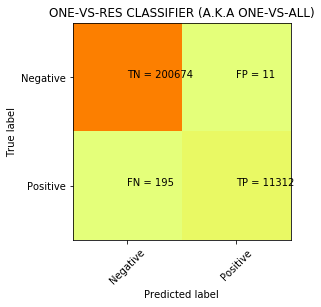

In [10]:
#==============[ One-vs-Rest classifier (a.k.a. One-vs-All ]=====================

for i in range(1, 2):
    
    # instantiate the base classifier.
    #lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
    lr = LogisticRegression(maxIter=10, regParam=0.001, elasticNetParam=0, tol=1E-6, fitIntercept=True )

    # instantiate the One Vs Rest Classifier.
    ovr = OneVsRest(classifier=lr)

    # train the multiclass model.
    ovrModel = ovr.fit(trainingData)

    # score the model on test data.
    predictions = ovrModel.transform(testData)

    # obtain evaluator.
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # compute the classification error on test data.
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy))
    print("\nAccuracy on Test Data = %g" % (accuracy*100))
    
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Accuracy = %g" % (accuracy*100))

    evaluatorf1 = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="f1")
    f1 = evaluatorf1.evaluate(predictions)
    print("f1 = %g" % (f1*100))
 
     #================================================================
    df = predictions.select('prediction', 'label')
    predictionAndLabels=df.rdd

    metrics = MulticlassMetrics(predictionAndLabels) 

    #accuracy=(cm[0][0]+cm[1][1])/cm.sum()
    #print(accuracy)

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)

    print("Recal: %g" %(r*100))
    print("Precision: %g" %(p*100))
    print("Accuracy: %g" %(a*100))

#=============================================================
    
    
    ovr_predictions = ovrModel.transform(testData)


    y_actu = ovr_predictions.select("label").toPandas()
    y_pred = ovr_predictions.select("prediction").toPandas()

    cm = confusion_matrix(y_actu, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('ONE-VS-RES CLASSIFIER (A.K.A ONE-VS-ALL)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    #TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    